In [2]:
# Install necessary packages
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install seaborn

# Download the dataset
!wget "https://istella.ai/?smd_process_download=1&download_id=4983" -O istella.tar.gz

# Untar the dataset
!tar -xvzf istella.tar.gz

--2024-12-07 15:59:51--  https://istella.ai/?smd_process_download=1&download_id=4983
Risoluzione di istella.ai (istella.ai)... 185.61.152.34
Connessione a istella.ai (istella.ai)|185.61.152.34|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://istella.ai/dataset/istella-s-letor.tar.gz [segue]
--2024-12-07 15:59:53--  https://istella.ai/dataset/istella-s-letor.tar.gz
Riutilizzo della connessione esistente a istella.ai:443.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 472075157 (450M) [application/x-gzip]
Salvataggio in: «istella.tar.gz»

istella.tar.gz      100%[===================>] 450,21M  5,34MB/s    in 87s     

2024-12-07 16:01:20 (5,16 MB/s) - «istella.tar.gz» salvato [472075157/472075157]

x istella-s-letor/
x istella-s-letor/README
x istella-s-letor/sample/
x istella-s-letor/istella-letor-LA.txt
x istella-s-letor/sample/train.txt: Can't unlink already-existing object
x istella-s-letor/sample/vali.txt: Can't unli

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set constants
MAX_TRAINING_QUERIES = 100
MAX_VALIDATION_QUERIES = 50
MAX_TEST_QUERIES = 50

# Define data file paths
train_file = '/content/istella-s-letor/sample/train.txt'
valid_file = '/content/istella-s-letor/sample/vali.txt'
test_file = '/content/istella-s-letor/sample/test.txt'

def parse_line(line):
    # Parse a single line of the dataset
    tokens = line.strip().split()
    label = int(tokens[0])
    qid = tokens[1].split(':')[1]
    features = {}
    for item in tokens[2:]:
        index, value = item.split(':')
        features[int(index)] = float(value)
    return label, qid, features

def load_data(file_path, max_queries):
    data = []
    query_ids = set()
    with open(file_path, 'r') as f:
        for line in f:
            label, qid, features = parse_line(line)
            if qid not in query_ids:
                if len(query_ids) >= max_queries:
                    break
                query_ids.add(qid)
            data.append((label, qid, features))
    return data

# Load training data
train_data = load_data(train_file, MAX_TRAINING_QUERIES)

# Load validation data
valid_data = load_data(valid_file, MAX_VALIDATION_QUERIES)

# Load test data
test_data = load_data(test_file, MAX_TEST_QUERIES)

print("Number of training samples:", len(train_data))
print("Number of validation samples:", len(valid_data))
print("Number of test samples:", len(test_data))

FileNotFoundError: [Errno 2] No such file or directory: '/content/istella-s-letor/sample/train.txt'

In [ ]:
# Convert data to DataFrames
def data_to_dataframe(data):
    labels = []
    qids = []
    features_list = []
    for label, qid, features in data:
        labels.append(label)
        qids.append(qid)
        features_list.append(features)
    df_features = pd.DataFrame(features_list)
    df_features['label'] = labels
    df_features['qid'] = qids
    return df_features

train_df = data_to_dataframe(train_data)
valid_df = data_to_dataframe(valid_data)
test_df = data_to_dataframe(test_data)

print("Training DataFrame shape:", train_df.shape)
print("Validation DataFrame shape:", valid_df.shape)
print("Test DataFrame shape:", test_df.shape)

# Replace very large numbers with NaN
def replace_large_numbers(df):
    df.replace(1.79769313486e+308, np.nan, inplace=True)
    df.replace(np.inf, np.nan, inplace=True)
    df.replace(-np.inf, np.nan, inplace=True)
    return df

train_df = replace_large_numbers(train_df)
valid_df = replace_large_numbers(valid_df)
test_df = replace_large_numbers(test_df)

# Check for missing values
def check_missing_values(df, name):
    missing_counts = df.isnull().sum()
    total_missing = missing_counts.sum()
    print(f"Total missing values in {name}: {total_missing}")
    if total_missing > 0:
        print(missing_counts[missing_counts > 0])

check_missing_values(train_df, "Training Data")
check_missing_values(valid_df, "Validation Data")
check_missing_values(test_df, "Test Data")

# Data Imputation

from sklearn.impute import SimpleImputer

def impute_missing_values(df):
    features = df.drop(columns=['label', 'qid']).columns
    imputer = SimpleImputer(strategy='mean') #metto la media al posto valori
    df[features] = imputer.fit_transform(df[features])
    return df

train_df = impute_missing_values(train_df)
valid_df = impute_missing_values(valid_df)
test_df = impute_missing_values(test_df)

# Verify that there are no missing values
check_missing_values(train_df, "Training Data")
check_missing_values(valid_df, "Validation Data")
check_missing_values(test_df, "Test Data")

Training DataFrame shape: (12210, 222)
Validation DataFrame shape: (5625, 222)
Test DataFrame shape: (3151, 222)
Total missing values in Training Data: 8144
1      2362
194    5782
dtype: int64
Total missing values in Validation Data: 4582
1      1241
194    3341
dtype: int64
Total missing values in Test Data: 1953
1       536
194    1417
dtype: int64
Total missing values in Training Data: 0
Total missing values in Validation Data: 0
Total missing values in Test Data: 0


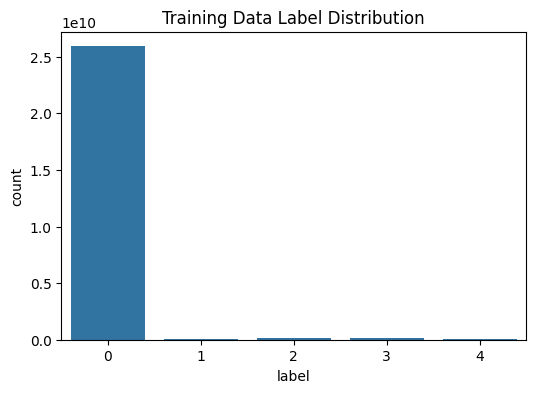

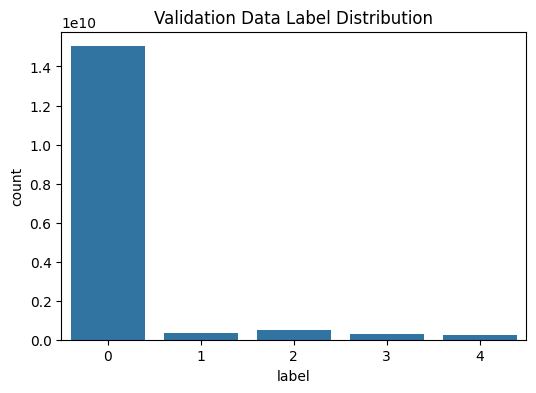

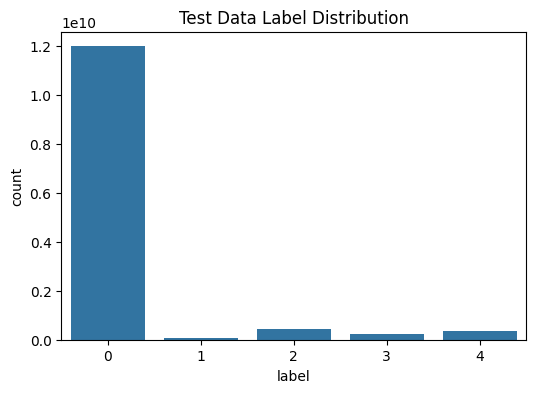

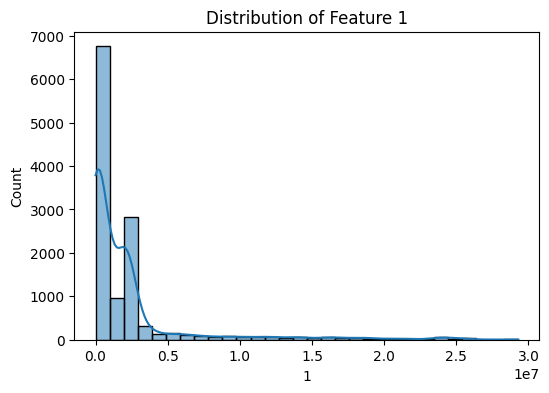

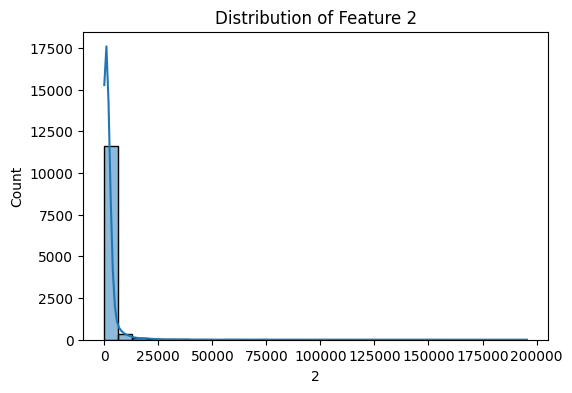

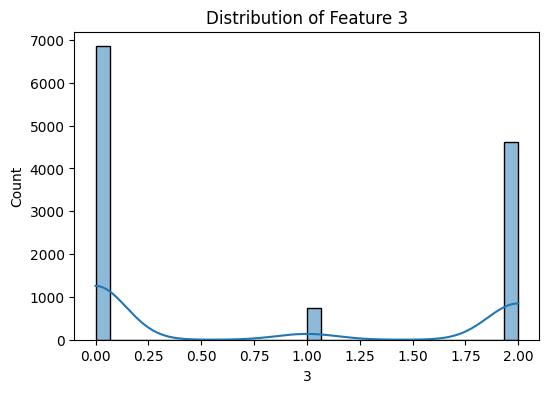

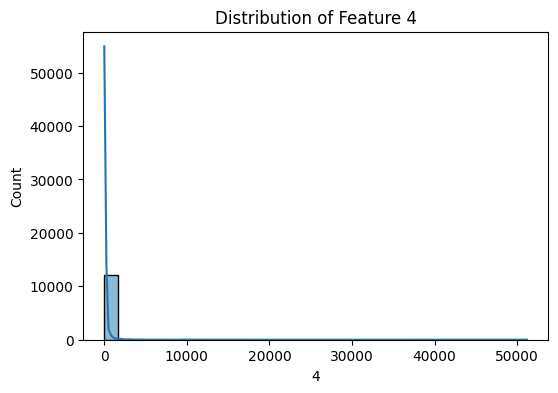

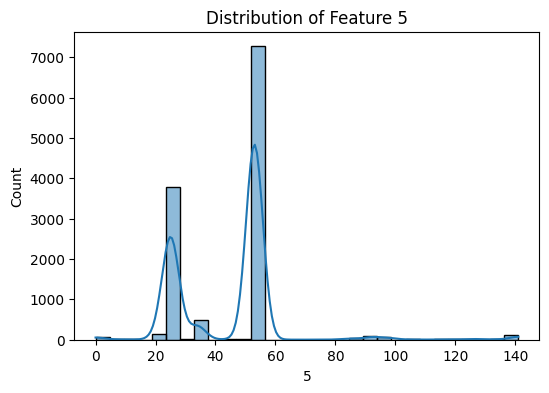

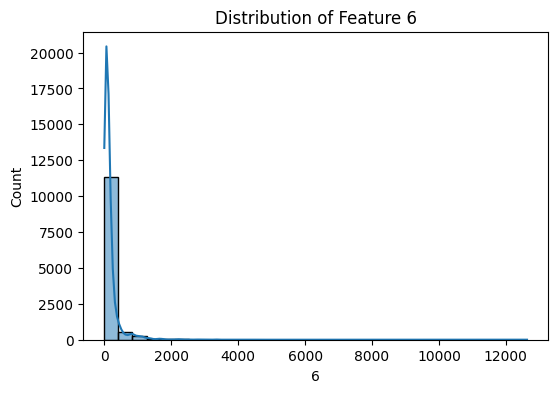

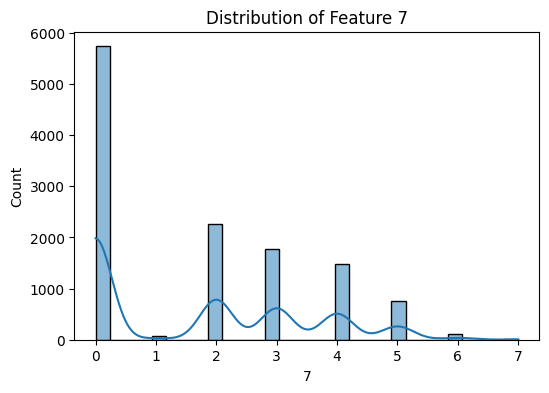

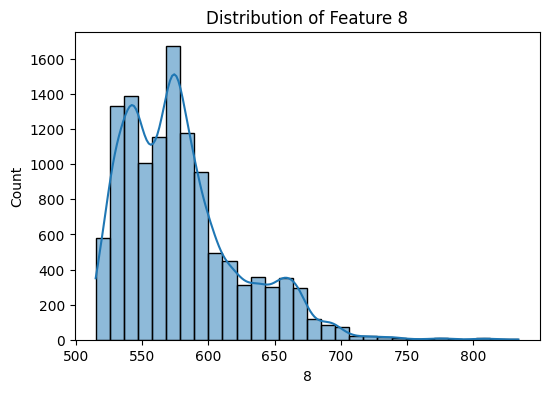

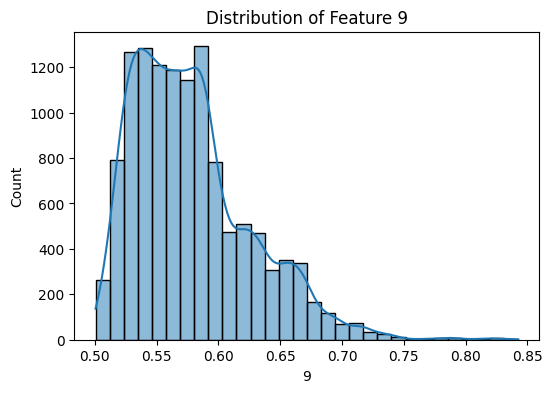

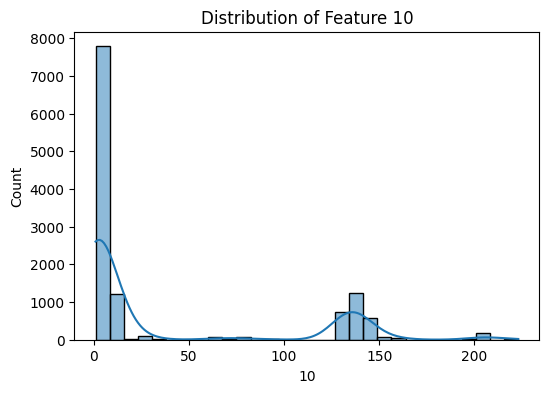

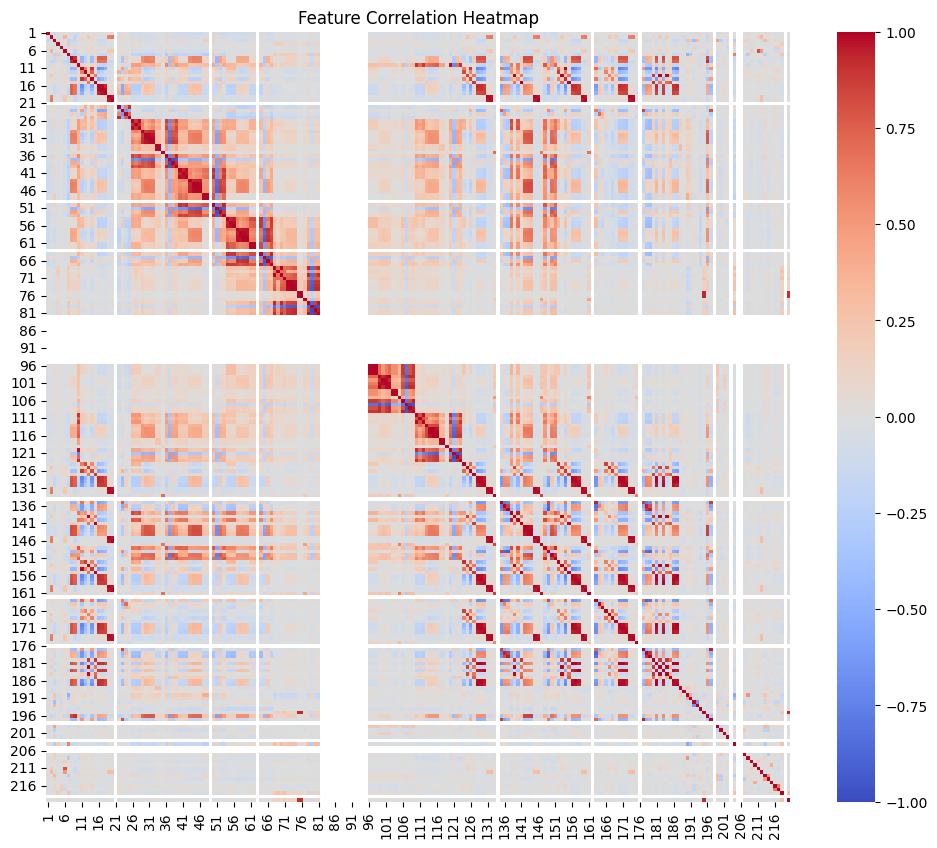

In [ ]:
# Visual Analytics

# Examine label distribution
def plot_label_distribution(df, title):
    plt.figure(figsize=(6,4))
    sns.countplot(x='label', data=df)
    plt.title(title)
    plt.show()

plot_label_distribution(train_df, "Training Data Label Distribution")
plot_label_distribution(valid_df, "Validation Data Label Distribution")
plot_label_distribution(test_df, "Test Data Label Distribution")

# Examine feature distributions
def plot_feature_distribution(df, feature, title):
    plt.figure(figsize=(6,4))
    sns.histplot(df[feature].dropna(), bins=30, kde=True)
    plt.title(title)
    plt.show()

# Plot distributions of some features
for feature in train_df.columns[:10]:  # Plot first 10 features
    if feature not in ['label', 'qid']:
        plot_feature_distribution(train_df, feature, f"Distribution of Feature {feature}")

# Correlation heatmap
plt.figure(figsize=(12,10))
corr = train_df.drop(columns=['label', 'qid']).corr()
sns.heatmap(corr, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
def modify_labels(df):
    df['label'] = df['label'].apply(lambda x: 1 if x >= 2 else 0)
    return df

train_df = modify_labels(train_df)
valid_df = modify_labels(valid_df)
test_df = modify_labels(test_df)

In [ ]:
# Separate features and labels
X_train = train_df.drop(columns=['label', 'qid'])
y_train = train_df['label']

X_valid = valid_df.drop(columns=['label', 'qid'])
y_valid = valid_df['label']

X_test = test_df.drop(columns=['label', 'qid'])
y_test = test_df['label']

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

# Logistic Regression
lr = LogisticRegression(max_iter=1000)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear']
}

lr_grid = GridSearchCV(lr, lr_params, cv=3, scoring='roc_auc', n_jobs=-1)
lr_grid.fit(X_train, y_train)

print("Best parameters for Logistic Regression:", lr_grid.best_params_)
print("Best ROC AUC for Logistic Regression:", lr_grid.best_score_)

Best parameters for Logistic Regression: {'C': 0.01, 'solver': 'liblinear'}
Best ROC AUC for Logistic Regression: 0.844110656307655


In [ ]:
# Decision Tree
dt = DecisionTreeClassifier()

dt_params = {
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10]
}

dt_grid = GridSearchCV(dt, dt_params, cv=3, scoring='roc_auc', n_jobs=-1)
dt_grid.fit(X_train, y_train)

print("Best parameters for Decision Tree:", dt_grid.best_params_)
print("Best ROC AUC for Decision Tree:", dt_grid.best_score_)

Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 10}
Best ROC AUC for Decision Tree: 0.8475667613581982


In [ ]:
# Random Forest
rf = RandomForestClassifier()

rf_params = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(rf, rf_params, cv=3, scoring='roc_auc', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Best parameters for Random Forest:", rf_grid.best_params_)
print("Best ROC AUC for Random Forest:", rf_grid.best_score_)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 500}
Best ROC AUC for Random Forest: 0.9313334366153448


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, ndcg_score

# Logistic Regression Best Model
best_lr = lr_grid.best_estimator_

# Decision Tree Best Model
best_dt = dt_grid.best_estimator_

# Random Forest Best Model
best_rf = rf_grid.best_estimator_

In [ ]:
def evaluate_model(model, X, y, dataset_name):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:,1]
    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    ndcg = ndcg_score([y], [y_proba])
    print(f"Evaluation on {dataset_name} Data")
    print("Accuracy:", accuracy)
    print("ROC AUC:", roc_auc)
    print("NDCG:", ndcg)
    print(classification_report(y, y_pred))

In [ ]:
# Evaluate Logistic Regression
print("Logistic Regression Performance:")
evaluate_model(best_lr, X_train, y_train, "Training")
evaluate_model(best_lr, X_valid, y_valid, "Validation")
evaluate_model(best_lr, X_test, y_test, "Test")

Logistic Regression Performance:
Evaluation on Training Data
Accuracy: 0.9255528255528256
ROC AUC: 0.8284176805354303
NDCG: 0.8148345189787775
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     11305
           1       0.33      0.00      0.01       905

    accuracy                           0.93     12210
   macro avg       0.63      0.50      0.49     12210
weighted avg       0.88      0.93      0.89     12210

Evaluation on Validation Data
Accuracy: 0.9096888888888889
ROC AUC: 0.7399162795501509
NDCG: 0.7932940161207739
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      5118
           1       0.00      0.00      0.00       507

    accuracy                           0.91      5625
   macro avg       0.45      0.50      0.48      5625
weighted avg       0.83      0.91      0.87      5625

Evaluation on Test Data
Accuracy: 0.8959060615677563
ROC AUC: 0.7067300763798818
NDCG: 0.78

In [ ]:
# Evaluate Decision Tree
print("Decision Tree Performance:")
evaluate_model(best_dt, X_train, y_train, "Training")
evaluate_model(best_dt, X_valid, y_valid, "Validation")
evaluate_model(best_dt, X_test, y_test, "Test")

Decision Tree Performance:
Evaluation on Training Data
Accuracy: 0.9542178542178542
ROC AUC: 0.9317403681449317
NDCG: 0.9326678470899681
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     11305
           1       0.71      0.64      0.67       905

    accuracy                           0.95     12210
   macro avg       0.84      0.81      0.83     12210
weighted avg       0.95      0.95      0.95     12210

Evaluation on Validation Data
Accuracy: 0.9203555555555556
ROC AUC: 0.8440032202544603
NDCG: 0.876521363168543
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      5118
           1       0.59      0.37      0.45       507

    accuracy                           0.92      5625
   macro avg       0.77      0.67      0.71      5625
weighted avg       0.91      0.92      0.91      5625

Evaluation on Test Data
Accuracy: 0.9047921294827039
ROC AUC: 0.6916358788926883
NDCG: 0.803923852

In [ ]:
# Evaluate Random Forest
print("Random Forest Performance:")
evaluate_model(best_rf, X_train, y_train, "Training")
evaluate_model(best_rf, X_valid, y_valid, "Validation")
evaluate_model(best_rf, X_test, y_test, "Test")

Random Forest Performance:
Evaluation on Training Data
Accuracy: 0.976003276003276
ROC AUC: 0.9944091623273328
NDCG: 0.9927850755052708
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     11305
           1       0.95      0.71      0.81       905

    accuracy                           0.98     12210
   macro avg       0.96      0.85      0.90     12210
weighted avg       0.98      0.98      0.97     12210

Evaluation on Validation Data
Accuracy: 0.9299555555555555
ROC AUC: 0.9362026586753794
NDCG: 0.9372659821187624
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5118
           1       0.83      0.28      0.42       507

    accuracy                           0.93      5625
   macro avg       0.88      0.64      0.69      5625
weighted avg       0.92      0.93      0.91      5625

Evaluation on Test Data
Accuracy: 0.9006664550936211
ROC AUC: 0.7491899103442552
NDCG: 0.842662936

In [ ]:
# Compare models
models = ['Logistic Regression', 'Decision Tree', 'Random Forest']
train_accuracies = []
valid_accuracies = []
test_accuracies = []

train_roc_aucs = []
valid_roc_aucs = []
test_roc_aucs = []

train_ndcgs = []
valid_ndcgs = []
test_ndcgs = []

for model_name, model in zip(models, [best_lr, best_dt, best_rf]):
    y_train_pred = model.predict(X_train)
    y_train_proba = model.predict_proba(X_train)[:,1]
    y_valid_pred = model.predict(X_valid)
    y_valid_proba = model.predict_proba(X_valid)[:,1]
    y_test_pred = model.predict(X_test)
    y_test_proba = model.predict_proba(X_test)[:,1]

    train_accuracies.append(accuracy_score(y_train, y_train_pred))
    valid_accuracies.append(accuracy_score(y_valid, y_valid_pred))
    test_accuracies.append(accuracy_score(y_test, y_test_pred))

    train_roc_aucs.append(roc_auc_score(y_train, y_train_proba))
    valid_roc_aucs.append(roc_auc_score(y_valid, y_valid_proba))
    test_roc_aucs.append(roc_auc_score(y_test, y_test_proba))

    train_ndcgs.append(ndcg_score([y_train], [y_train_proba]))
    valid_ndcgs.append(ndcg_score([y_valid], [y_valid_proba]))
    test_ndcgs.append(ndcg_score([y_test], [y_test_proba]))

# Create DataFrame to compare results
comparison_df = pd.DataFrame({
    'Model': models,
    'Train Accuracy': train_accuracies,
    'Validation Accuracy': valid_accuracies,
    'Test Accuracy': test_accuracies,
    'Train ROC AUC': train_roc_aucs,
    'Validation ROC AUC': valid_roc_aucs,
    'Test ROC AUC': test_roc_aucs,
    'Train NDCG': train_ndcgs,
    'Validation NDCG': valid_ndcgs,
    'Test NDCG': test_ndcgs
})

print(comparison_df)

                 Model  Train Accuracy  Validation Accuracy  Test Accuracy  \
0  Logistic Regression        0.925553             0.909689       0.895906   
1        Decision Tree        0.954218             0.920356       0.904792   
2        Random Forest        0.976003             0.929956       0.900666   

   Train ROC AUC  Validation ROC AUC  Test ROC AUC  Train NDCG  \
0       0.828418            0.739916      0.706730    0.814835   
1       0.931740            0.844003      0.691636    0.932668   
2       0.994409            0.936203      0.749190    0.992785   

   Validation NDCG  Test NDCG  
0         0.793294   0.780835  
1         0.876521   0.803924  
2         0.937266   0.842663  


In [ ]:
# Conclusion
print("Based on the comparison, we can see that:")

best_model = comparison_df.loc[comparison_df['Validation ROC AUC'].idxmax()]
print(f"The model with the highest validation ROC AUC is {best_model['Model']}.")

print("Therefore, we should use the", best_model['Model'])

Based on the comparison, we can see that:
The model with the highest validation ROC AUC is Random Forest.
Therefore, we should use the Random Forest
